In [1]:
import gym
import gym_simple
import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
env = gym.make('PutBallInBoxEnvRandom5x5-v0')

print(env.action_space)
print(env.observation_space)

actions = ['up', 'down', 'left', 'right', 'up-right', 'up-left',
    'down-right', 'down-left', 'pick-up', 'put-down']

Discrete(10)
Box(5, 5, 5, 5, 5, 5, 3)


In [3]:
class QNetwork:
    def __init__(self, learning_rate, state_size, action_size, hidden_size, name='QNetwork'):
        with tf.variable_scope(name):
            # State inputs to the Q-network
            self.inputs_ = tf.placeholder(tf.float32, [None, state_size], name='inputs')

            # One hot encode the actions to later choose the Q-value for the action
            self.actions_ = tf.placeholder(tf.int32, [None], name='actions')
            one_hot_actions = tf.one_hot(self.actions_, action_size)

            # Target Q values for training
            self.targetQs_ = tf.placeholder(tf.float32, [None], name='target')

            # ReLU hidden layers
            self.fc1 = tf.contrib.layers.fully_connected(self.inputs_, hidden_size)
            self.fc2 = tf.contrib.layers.fully_connected(self.fc1, hidden_size)
            
            # Linear hidden layer
            self.fc3 = tf.contrib.layers.fully_connected(self.fc2, hidden_size,
                                                         activation_fn=None)

            # Linear output layer
            self.output = tf.contrib.layers.fully_connected(self.fc3, action_size,
                                                            activation_fn=None)

            # Minimize loss: (targetQ - Q)^2
            self.Q = tf.reduce_sum(tf.multiply(self.output, one_hot_actions), axis=1)
            self.loss = tf.reduce_mean(tf.square(self.targetQs_ - self.Q))
            self.opt = tf.train.AdamOptimizer(learning_rate).minimize(self.loss)

In [4]:
# Environment specific parameters
action_size = env.action_space.n
state_size = len(env.observation_space.shape)

# Training parameters
train_episodes = 2000         # max number of episodes to learn from
max_steps = 1000              # max steps in an episode
gamma = 0.95                  # future reward discount

# Exploration parameters
explore_start = 1.0           # exploration probability at start
explore_stop = 0.1            # minimum exploration probability
decay_rate = 0.00005          # exponential decay rate for exploration prob

# Network parameters
hidden_size = 100             # number of units in each Q-network hidden layer
learning_rate = 0.0001        # Q-network learning rate

# Memory parameters
memory_size = 50000           # memory capacity
batch_size = 5000             # experience mini-batch size
pretrain_length = batch_size  # number experiences to pretrain the memory

# Update Target Network
c_steps = 100                  # every c steps

In [5]:
from collections import deque

class Memory:
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    # experience: (state, action, reward, next_state)
    def add(self, experience):
        self.buffer.append(experience)

    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)),
                               size=batch_size,
                               replace=False)
        return [self.buffer[ii] for ii in idx]

In [6]:
# Initialize the simulation
state, reward, done, _ = env.reset()

memory = Memory(max_size=memory_size)

# Make random actions and store the experiences to pre-fill the memory
for ii in range(pretrain_length):
    # Uncomment the line below to watch the simulation
    #env.render()

    # Make a random action
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)

    if done:
        # Add experience to memory
        memory.add((state, action, reward, next_state))

        # Start new episode
        state, reward, done, _ = env.reset()

    else:
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        state = next_state

In [7]:
def updateTargetNetwork(tfVars):
    total_vars = len(tfVars)
    op_holder = []
    for idx,var in enumerate(tfVars[0:total_vars//2]):
        op_holder.append(tfVars[idx+total_vars//2].assign(var.value()))
    return op_holder

def updateTarget(op_holder,sess):
    for op in op_holder:
        sess.run(op)

In [8]:
# Train the model following DQN algorithm
tf.reset_default_graph()
mainQN = QNetwork(name='main', state_size=state_size, action_size=action_size,
                  hidden_size=hidden_size, learning_rate=learning_rate)
targetQN = QNetwork(name='target', state_size=state_size, action_size=action_size,
                    hidden_size=hidden_size, learning_rate=learning_rate)

init = tf.global_variables_initializer()

saver = tf.train.Saver()

trainables = tf.trainable_variables()

targetOps = updateTargetNetwork(trainables)

cum_avg_reward_lst = []
with tf.Session() as sess:
    # Initialize variables
    sess.run(init)

    step = 0
    total_reward = 0
    for ep in range(1, train_episodes):
        state, reward, done, _ = env.reset()
        t = 0
        while t < max_steps:
            step += 1
            # Uncomment this next line to watch the training
            #env.render()

            # Explore or Exploit
            explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step)
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()
            else:
                # Get action from Q-network
                feed = {mainQN.inputs_: state.reshape((1, *state.shape))}
                Qs = sess.run(mainQN.output, feed_dict=feed)
                action = np.argmax(Qs)

            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)

            total_reward += reward

            if done:
                # Add experience to memory
                memory.add((state, action, reward, next_state))

            else:
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                state = next_state
                t += 1

            # Sample mini-batch from memory
            batch = memory.sample(batch_size)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            rewards = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])

            # Train network
            target_Qs = sess.run(targetQN.output, feed_dict={targetQN.inputs_: next_states})

            if done:
                targets = rewards
            else:
                targets = rewards + gamma * np.max(target_Qs, axis=1)

            loss, _ = sess.run([mainQN.loss, mainQN.opt],
                                feed_dict={mainQN.inputs_: states,
                                           mainQN.targetQs_: targets,
                                           mainQN.actions_: actions})
            # After every C steps copy Q network to target network periodically
            # use target network to calculate target Qs
            if  t % c_steps == 0:
               updateTarget(targetOps,sess)

            if done: break
        cum_avg_reward = total_reward/(ep)
        cum_avg_reward_lst.append(cum_avg_reward)

    saver.save(sess, "checkpoints/putballinbox")

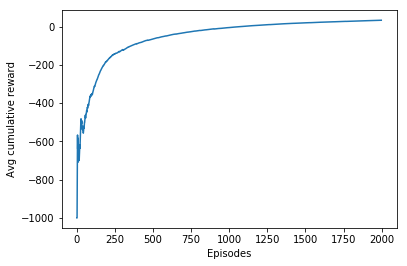

In [11]:
plt.plot(cum_avg_reward_lst)
plt.ylabel('Avg cumulative reward')
plt.xlabel('Episodes')
plt.show()

In [12]:
# Test the trained DQN model
import time
import copy

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    # Load meta graph and restore weights
    saver = tf.train.import_meta_graph('checkpoints/putballinbox.meta')
    saver.restore(sess,tf.train.latest_checkpoint('checkpoints/'))

    graph = tf.get_default_graph()
    inputs_tensor = graph.get_tensor_by_name("main/inputs:0")
    output_tensor = graph.get_tensor_by_name("main/fully_connected_3/BiasAdd:0")


    target_output_tensor = tf.contrib.copy_graph.get_copied_op(output_tensor, graph)

    total_reward = 0
    n_episodes = 10
    n_steps = 20

    for i_episode in range(n_episodes):
        print('Episode: ' + str(i_episode+1))
        state,_,_,_ = env.reset()
        for t in range(n_steps):
            env.render()
            feed = {inputs_tensor: state.reshape((1, *state.shape))}
            Qs = sess.run(target_output_tensor, feed_dict=feed)
            action = np.argmax(Qs)
            next_state, r, done, _ = env.step(action)
            state = next_state
            total_reward += r
            if done:
                print("Reached the goal after {} timesteps".format(t+1))
                break
            time.sleep(1)
        if not done:
            print("Didnt reach the goal after {} timesteps".format(n_steps))
        print(total_reward/(i_episode + 1))
    env.close()

INFO:tensorflow:Restoring parameters from checkpoints/putballinbox
Episode: 1
Reached the goal after 13 timesteps
88.0
Episode: 2
Reached the goal after 7 timesteps
91.0
Episode: 3
Didnt reach the goal after 20 timesteps
54.0
Episode: 4
Reached the goal after 14 timesteps
62.25
Episode: 5
Didnt reach the goal after 20 timesteps
45.8
Episode: 6
Didnt reach the goal after 20 timesteps
34.833333333333336
Episode: 7
Reached the goal after 16 timesteps
42.0
Episode: 8
Reached the goal after 13 timesteps
47.75
Episode: 9
Reached the goal after 16 timesteps
51.888888888888886
Episode: 10
Reached the goal after 16 timesteps
55.2


In [ ]:
TODO: HER (Hindsight Experience Replay)
...